In [1]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler

In [2]:
images_dir = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/images"
images_mask = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/labels"

images_files = os.listdir(images_dir)
images_mask_files = os.listdir(images_mask)

In [3]:
print(len(os.listdir(images_dir)))
print(len(os.listdir(images_mask)))

720
720


In [4]:
data = ["label", 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
points = np.array(data[1:], dtype = np.float32).reshape(-1,2)
print(points)
print(points[:,0])
print(points[:,1])

[[1. 2.]
 [3. 4.]
 [5. 6.]]
[1. 3. 5.]
[2. 4. 6.]


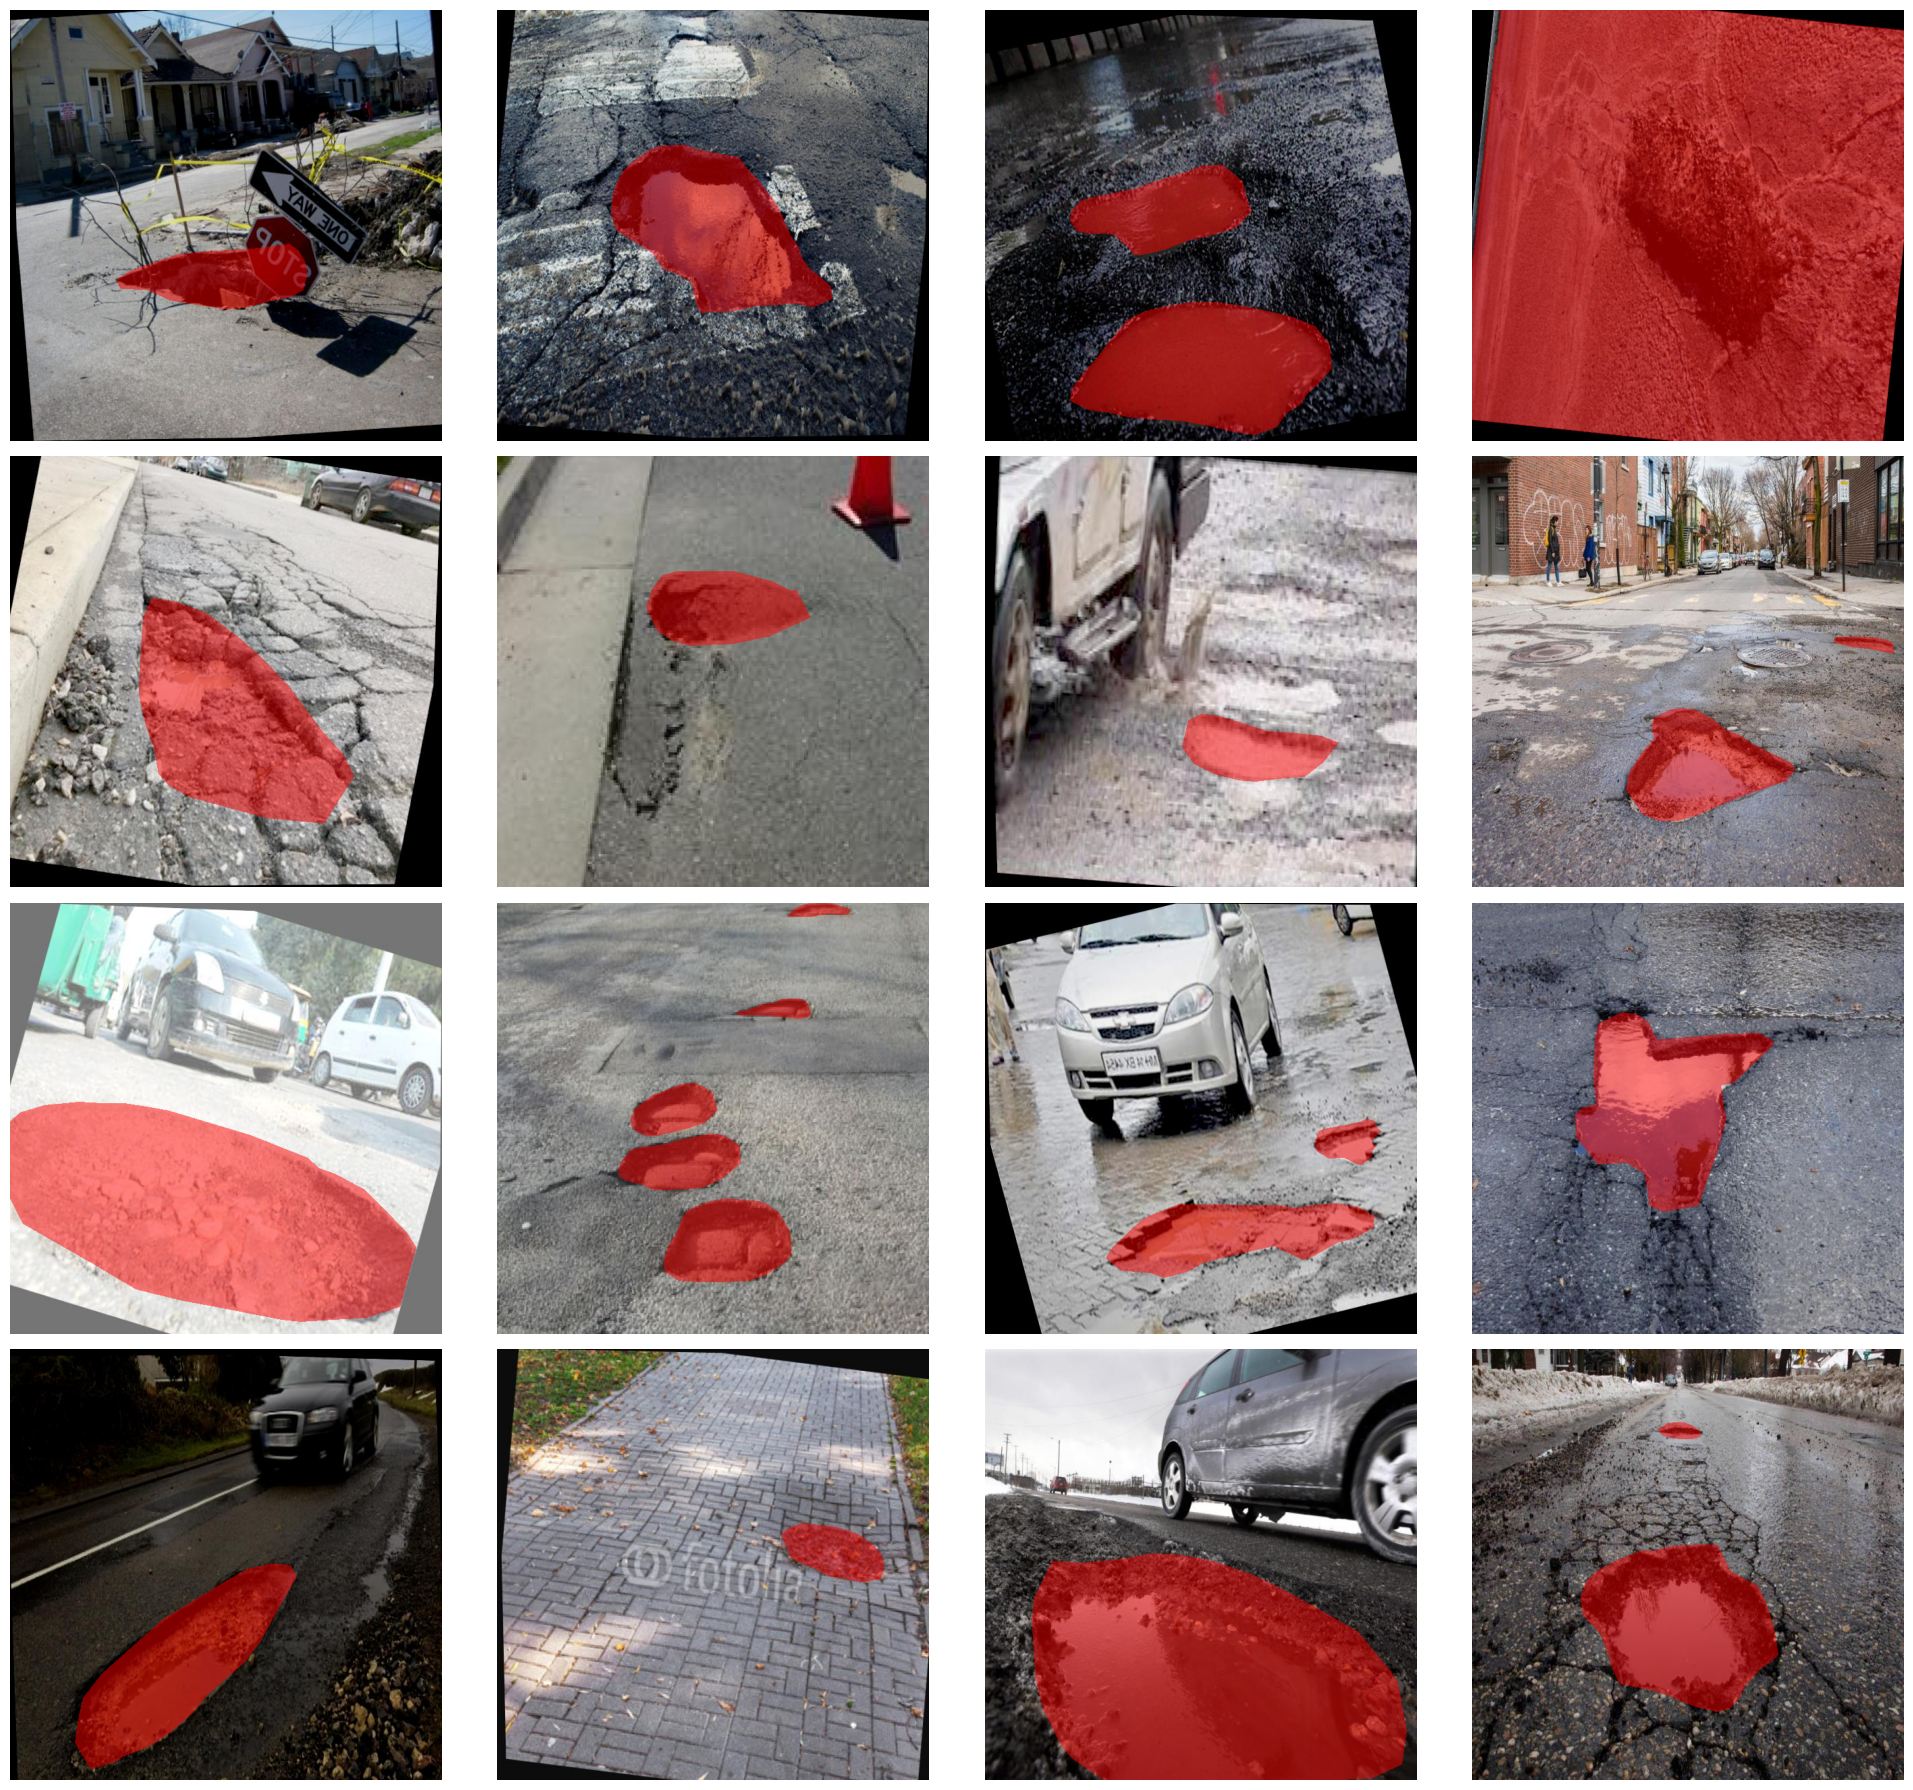

In [5]:
images_dir = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/images"
annotations_dir = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/labels"

images = os.listdir(images_dir)

fig, ax = plt.subplots(4, 4, figsize = (20,18))
ax = ax.ravel()

alpha = 0.5

class_names = ["pothole"]
class_colors = {
    0: (255, 0, 0)}

def draw_polygons(image, annotations_dir):
  overlay = image.copy()
  mask = np.zeros(image.shape[:2], dtype = np.uint8)

  with open((annotations_dir), "r") as f:
    for line in f:
      # print("Line ==> ", line)
      data = line.strip().split()
      # print("Data ==> ", data)
      class_id = int(data[0])
      # print("Class ID ==> ", class_id)
      points = np.array(data[1:], dtype = np.float32).reshape(-1,2)

      h, w, _ = image.shape
      points[:,0] *= w
      points[:,1] *= h
      points = points.astype(np.int32)

      cv2.fillPoly(overlay, [points], class_colors[class_id])

      cv2.fillPoly(mask, [points], 255)

  blended_image = image.copy
  blended_image = cv2.addWeighted(image, alpha, overlay, 1 - alpha, 0)

  return blended_image

for i in range(16):
  img = random.choice(images)
  img_path = os.path.join(images_dir, img)
  annotations_path = os.path.join(annotations_dir, img[:-4] + ".txt")

  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  if os.path.exists(annotations_path):
    image = draw_polygons(image, annotations_path)

  ax[i].imshow(image)
  ax[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DecoderBlock(nn.Module):

    def __init__(self, conv_in_channels, conv_out_channels, up_in_channels=None, up_out_channels=None):
        super().__init__()
        if up_in_channels is None:
            up_in_channels = conv_in_channels
        if up_out_channels is None:
            up_out_channels = conv_out_channels

        self.up = nn.ConvTranspose2d(up_in_channels, up_out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(conv_in_channels, conv_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1) 
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        if diffY > 0 or diffX > 0:
            pad_left = diffX // 2 if diffX > 0 else 0
            pad_right = diffX - pad_left if diffX > 0 else 0
            pad_top = diffY // 2 if diffY > 0 else 0
            pad_bottom = diffY - pad_top if diffY > 0 else 0
            x1 = F.pad(x1, [pad_left, pad_right, pad_top, pad_bottom])

        if x1.size(2) > x2.size(2) or x1.size(3) > x2.size(3):
            x1 = x1[:, :, :x2.size(2), :x2.size(3)]

        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

class UnetResnet34(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        resnet34 = torchvision.models.resnet34(pretrained=True)
        filters = [64, 128, 256, 512]

        self.firstlayer = nn.Sequential(*list(resnet34.children())[:3])
        self.maxpool = list(resnet34.children())[3]
        self.encoder1 = resnet34.layer1
        self.encoder2 = resnet34.layer2
        self.encoder3 = resnet34.layer3
        self.encoder4 = resnet34.layer4


        self.bridge = nn.Sequential(
            nn.Conv2d(filters[3], filters[3]*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[3]*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )

        self.decoder1 = DecoderBlock(conv_in_channels=filters[3]*2, conv_out_channels=filters[3])
        self.decoder2 = DecoderBlock(conv_in_channels=filters[3], conv_out_channels=filters[2])
        self.decoder3 = DecoderBlock(conv_in_channels=filters[2], conv_out_channels=filters[1])
        self.decoder4 = DecoderBlock(conv_in_channels=filters[1], conv_out_channels=filters[0])
        self.decoder5 = DecoderBlock(
            conv_in_channels=filters[1], conv_out_channels=filters[0], up_in_channels=filters[0], up_out_channels=filters[0]
        )

        self.lastlayer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=filters[0], out_channels=filters[0], kernel_size=2, stride=2),
            nn.Conv2d(filters[0], n_classes, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        e1 = self.firstlayer(x)
        maxe1 = self.maxpool(e1)
        e2 = self.encoder1(maxe1)
        e3 = self.encoder2(e2)
        e4 = self.encoder3(e3)
        e5 = self.encoder4(e4)
        
        c = self.bridge(e5)
        
        d1 = self.decoder1(c, e5)
        d2 = self.decoder2(d1, e4)
        d3 = self.decoder3(d2, e3)
        d4 = self.decoder4(d3, e2)
        d5 = self.decoder5(d4, e1)

        out = self.lastlayer(d5)

        return out
model = UnetResnet34(n_classes=2).to(device)

Using device: cuda


d:\Python\AI\envs\aio2024_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\AI\envs\aio2024_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class SegmenDataset(Dataset):
  def __init__(self, images_dir, annotations_dir, image_size = (224, 224), transform=None):
    self.images_dir = images_dir
    self.annotations_dir = annotations_dir
    self.image_filenames = sorted(os.listdir(images_dir))
    self.annotation_filenames = sorted(os.listdir(annotations_dir))
    self.image_size = image_size
    self.transform = transform

    self.class_labels = {
        0: "BG",
        1: "Pothole"
    }

  def __len__(self):
    return len(self.image_filenames)

  def __getitem__(self, index):
    image_path = os.path.join(self.images_dir, self.image_filenames[index])
    annotation_path = os.path.join(self.annotations_dir, self.annotation_filenames[index])

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    mask = np.zeros((h,w), dtype=np.uint8)

    if os.path.exists(annotation_path):
      with open(annotation_path, "r") as f:
        for line in f:
          data = line.strip().split()
          class_id = int(data[0])
          points = np.array(data[1:], dtype=np.float32).reshape(-1,2)

          points[:,0] *= w
          points[:,1] *= h
          points = points.astype(np.int32)

          cv2.fillPoly(mask, [points], 1)

    image = cv2.resize(image, self.image_size)
    mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)

    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image, mask = augmented["image"], augmented["mask"]

    return image, torch.tensor(mask, dtype=torch.long)

In [8]:
transform = A.Compose([
  A. Resize(224,224),
  A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
  ToTensorV2()
])

# Directories
train_images_dir = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/images"
train_images_mask = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/train/labels"
val_images_dir = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/valid/images"
val_images_mask = "D:/Hackathon/OGa/Pothole_Image_Segmentation_Datasets/valid/labels"
# Load dataset
train_dataset = SegmenDataset(train_images_dir, train_images_mask, transform=transform)
val_dataset = SegmenDataset(val_images_dir, val_images_mask, transform=transform)
# DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
# Define Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
model = UnetResnet34().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
print(len(train_loader))
print(len(val_loader))
print(len(val_dataset))
print(len(train_dataset))

90
8
60
720


C:\Users\Van Quyet\AppData\Local\Temp\ipykernel_7100\4008451704.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


Epoch [1/10] Train Loss: 0.3947 Val Loss: 0.2165 Train IoU: 0.5971 Val IoU: 0.7495
Epoch [2/10] Train Loss: 0.1698 Val Loss: 0.1977 Train IoU: 0.7913 Val IoU: 0.7517
Epoch [3/10] Train Loss: 0.1109 Val Loss: 0.1611 Train IoU: 0.8522 Val IoU: 0.8090
Epoch [4/10] Train Loss: 0.0869 Val Loss: 0.2053 Train IoU: 0.8784 Val IoU: 0.7900
Epoch [5/10] Train Loss: 0.0668 Val Loss: 0.2076 Train IoU: 0.9043 Val IoU: 0.7914
Epoch [6/10] Train Loss: 0.0571 Val Loss: 0.1896 Train IoU: 0.9162 Val IoU: 0.8006
Epoch [7/10] Train Loss: 0.0494 Val Loss: 0.1956 Train IoU: 0.9279 Val IoU: 0.8147
Epoch [8/10] Train Loss: 0.0481 Val Loss: 0.1935 Train IoU: 0.9281 Val IoU: 0.8031
Epoch [9/10] Train Loss: 0.0381 Val Loss: 0.2046 Train IoU: 0.9414 Val IoU: 0.8076
Epoch [10/10] Train Loss: 0.0336 Val Loss: 0.1861 Train IoU: 0.9476 Val IoU: 0.8158


Text(0.5, 1.0, 'Mean')

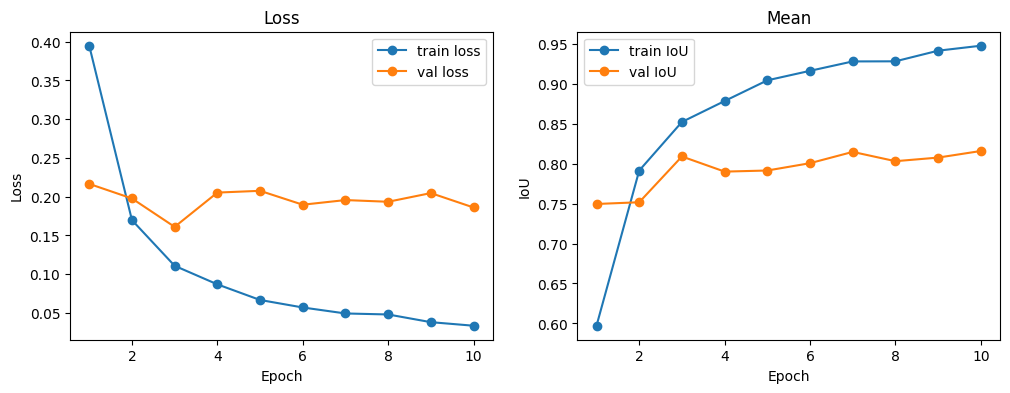

In [ ]:
import matplotlib.pyplot as plt

n_classes = 2  
train_losses, val_losses = [], []
train_ious, val_ious = [], []

def compute_iou_batch(pred, target, n_classes=2):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for c in range(n_classes):
        pred_c = (pred == c)
        target_c = (target == c)
        inter = (pred_c & target_c).sum().item()
        union = (pred_c | target_c).sum().item()
        if union == 0:
            iou = float('nan')
        else:
            iou = inter / union
        ious.append(iou)
    # mean over classes ignoring NaNs
    valid = [x for x in ious if not (x != x)]
    return (sum(valid) / len(valid)) if len(valid) else 0.0

best_loss = float("inf")
save_path = "best_model.pth"
EPOCHS = 10

model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_iou = 0.0
    n_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)               
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)  
        epoch_train_iou += compute_iou_batch(preds.cpu(), masks.cpu(), n_classes)
        n_batches += 1

    avg_train_loss = epoch_train_loss / max(1, n_batches)
    avg_train_iou = epoch_train_iou / max(1, n_batches)
    train_losses.append(avg_train_loss)
    train_ious.append(avg_train_iou)

    # validation
    model.eval()
    epoch_val_loss = 0.0
    epoch_val_iou = 0.0
    n_val_batches = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            epoch_val_loss += val_loss.item()

            preds = torch.argmax(outputs, dim=1)
            epoch_val_iou += compute_iou_batch(preds.cpu(), masks.cpu(), n_classes)
            n_val_batches += 1

    avg_val_loss = epoch_val_loss / max(1, n_val_batches)
    avg_val_iou = epoch_val_iou / max(1, n_val_batches)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_val_iou)
    
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} "
          f"Train IoU: {avg_train_iou:.4f} Val IoU: {avg_val_iou:.4f}")

# Vẽ biểu đồ Loss và IoU
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label='train loss', marker='o')
plt.plot(range(1,len(val_losses)+1), val_losses, label='val loss', marker='o')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(range(1,len(train_ious)+1), train_ious, label='train IoU', marker='o')
plt.plot(range(1,len(val_ious)+1), val_ious, label='val IoU', marker='o')
plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.legend(); plt.title('Mean')

In [ ]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UnetResnet34(n_classes=2).to(device)

state = torch.load("best_model.pth", map_location=device)
model.load_state_dict(state)
model.eval()

print("model device:", next(model.parameters()).device)

summary(model, input_size=(3, 224, 224), batch_size=8)

model device: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 112, 112]           9,408
       BatchNorm2d-2          [8, 64, 112, 112]             128
              ReLU-3          [8, 64, 112, 112]               0
         MaxPool2d-4            [8, 64, 56, 56]               0
            Conv2d-5            [8, 64, 56, 56]          36,864
       BatchNorm2d-6            [8, 64, 56, 56]             128
              ReLU-7            [8, 64, 56, 56]               0
            Conv2d-8            [8, 64, 56, 56]          36,864
       BatchNorm2d-9            [8, 64, 56, 56]             128
             ReLU-10            [8, 64, 56, 56]               0
       BasicBlock-11            [8, 64, 56, 56]               0
           Conv2d-12            [8, 64, 56, 56]          36,864
      BatchNorm2d-13            [8, 64, 56, 56]             128
             ReLU-

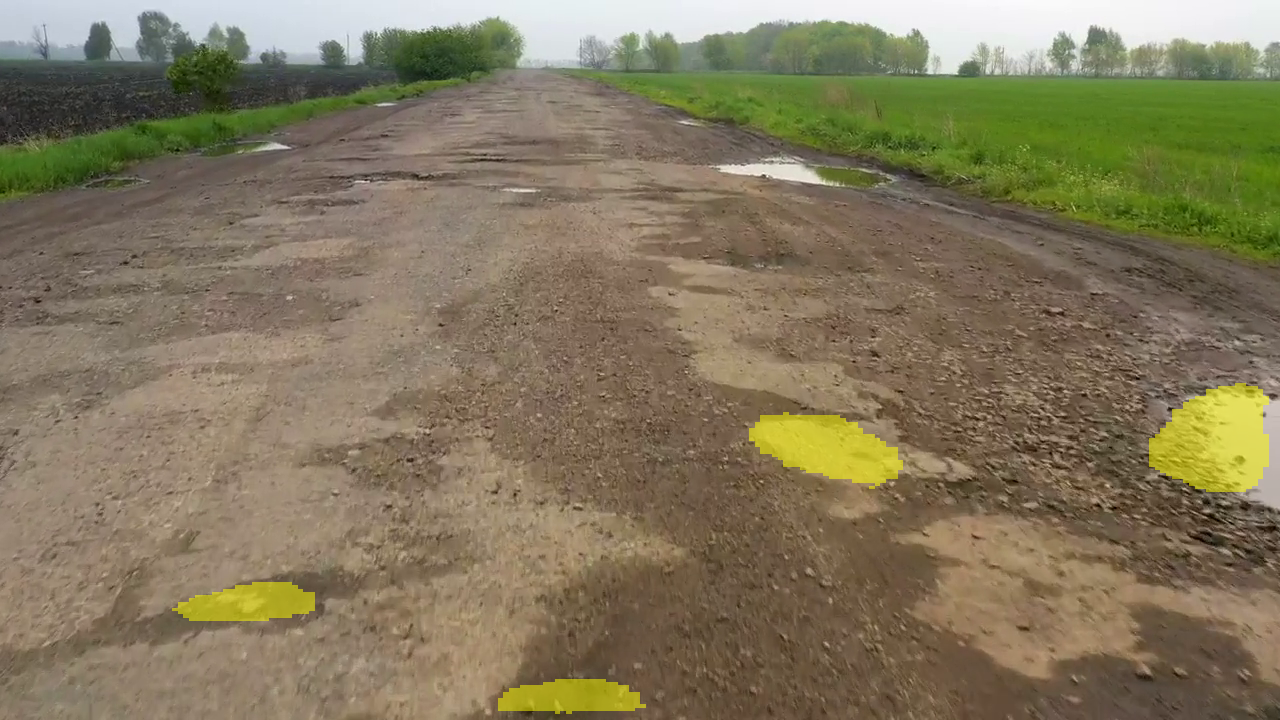

Finished displaying video.


In [ ]:
import os
import random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_first=False):
        super().__init__()
        layers = []
        if not is_first:
            layers.append(nn.MaxPool2d(2))
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)
    def forward(self, x):
        return self.block(x)

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    def forward(self, x, skip):
        x = self.up(x)
        diffY = skip.size(2) - x.size(2)
        diffX = skip.size(3) - x.size(3)
        skip = skip[:, :,
                    diffY//2 : skip.size(2)-(diffY-diffY//2),
                    diffX//2 : skip.size(3)-(diffX-diffX//2)]
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class DecoderBlock(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, conv_in_channels, conv_out_channels, up_in_channels=None, up_out_channels=None):
        super().__init__()
        if up_in_channels is None:
            up_in_channels = conv_in_channels
        if up_out_channels is None:
            up_out_channels = conv_out_channels

        self.up = nn.ConvTranspose2d(up_in_channels, up_out_channels, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(conv_in_channels, conv_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(conv_out_channels, conv_out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)  
        diffY = x2.size(2) - x1.size(2)
        diffX = x2.size(3) - x1.size(3)

        if diffY > 0 or diffX > 0:
            pad_left = diffX // 2 if diffX > 0 else 0
            pad_right = diffX - pad_left if diffX > 0 else 0
            pad_top = diffY // 2 if diffY > 0 else 0
            pad_bottom = diffY - pad_top if diffY > 0 else 0
            x1 = F.pad(x1, [pad_left, pad_right, pad_top, pad_bottom])

        if x1.size(2) > x2.size(2) or x1.size(3) > x2.size(3):
            x1 = x1[:, :, :x2.size(2), :x2.size(3)]

        x = torch.cat([x1, x2], dim=1)
        return self.conv(x)

class UnetResnet34(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        resnet34 = torchvision.models.resnet34(pretrained=True)
        filters = [64, 128, 256, 512]

        self.firstlayer = nn.Sequential(*list(resnet34.children())[:3])
        self.maxpool = list(resnet34.children())[3]
        self.encoder1 = resnet34.layer1
        self.encoder2 = resnet34.layer2
        self.encoder3 = resnet34.layer3
        self.encoder4 = resnet34.layer4

        self.bridge = nn.Sequential(
            nn.Conv2d(filters[3], filters[3]*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[3]*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )

        self.decoder1 = DecoderBlock(conv_in_channels=filters[3]*2, conv_out_channels=filters[3])
        self.decoder2 = DecoderBlock(conv_in_channels=filters[3], conv_out_channels=filters[2])
        self.decoder3 = DecoderBlock(conv_in_channels=filters[2], conv_out_channels=filters[1])
        self.decoder4 = DecoderBlock(conv_in_channels=filters[1], conv_out_channels=filters[0])
        self.decoder5 = DecoderBlock(
            conv_in_channels=filters[1], conv_out_channels=filters[0], up_in_channels=filters[0], up_out_channels=filters[0]
        )

        self.lastlayer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=filters[0], out_channels=filters[0], kernel_size=2, stride=2),
            nn.Conv2d(filters[0], n_classes, kernel_size=3, padding=1, bias=False)
        )
    
    def forward(self, x):
        e1 = self.firstlayer(x)
        maxe1 = self.maxpool(e1)
        e2 = self.encoder1(maxe1)
        e3 = self.encoder2(e2)
        e4 = self.encoder3(e3)
        e5 = self.encoder4(e4)
        
        c = self.bridge(e5)
        
        d1 = self.decoder1(c, e5)
        d2 = self.decoder2(d1, e4)
        d3 = self.decoder3(d2, e3)
        d4 = self.decoder4(d3, e2)
        d5 = self.decoder5(d4, e1)

        out = self.lastlayer(d5)

        return out

# --- load model ---
model_path = r"D:\Hackathon\OGa\best_model.pth"
model = UnetResnet34(n_classes=2).to(device)
state = torch.load(model_path, map_location=device)
model.load_state_dict(state)
model.eval()

# --- test images ---
def process_video_show(video_path, model, device, target_size=(224,224), threshold=0.5,
                       show_window=True, show_in_notebook=False, max_frames=None, output_path=None):
    cap = cv2.VideoCapture(video_path)

    if show_in_notebook:
        from IPython.display import display, clear_output

    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    writer = None
    if output_path is not None:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # hoặc 'XVID'
        writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))

    transform_vid = T.Compose([
        T.Resize(target_size),
        T.ToTensor(),
        T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])

    model.eval()
    idx = 0
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil = Image.fromarray(rgb)
            inp = transform_vid(pil).unsqueeze(0).to(device)
            out_logits = model(inp)

            if out_logits.size(1) == 1:
                prob = torch.sigmoid(out_logits).squeeze(0).squeeze(0).cpu().numpy()
            else:
                prob = torch.softmax(out_logits, dim=1)[0,1].cpu().numpy()
            pred_mask = (prob > threshold).astype(np.uint8)

            mask_full = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)
            overlay = np.zeros_like(frame, dtype=np.uint8)
            overlay[..., 1][mask_full == 1] = 255
            overlay[..., 2][mask_full == 1] = 255

            alpha = 0.5
            blended = frame.copy()
            blended[mask_full == 1] = (frame[mask_full == 1] * (1 - alpha) + overlay[mask_full == 1] * alpha).astype(np.uint8)

            if writer is not None:
                writer.write(blended)

            if show_window:
                cv2.imshow("Pothole Pred", blended)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if show_in_notebook:
                clear_output(wait=True)
                display(Image.fromarray(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)))

            idx += 1
            if max_frames is not None and idx >= max_frames:
                break

    cap.release()
    if writer is not None:
        writer.release()
    if show_window:
        cv2.destroyAllWindows()
    print("Finished displaying video.")

process_video_show("D:/Hackathon/OGa/sample_video.mp4", model, device, show_window=False, show_in_notebook=True, 
                   max_frames=500,
                   output_path="D:/Hackathon/OGa/output_video.mp4")
